In [28]:
%load_ext autoreload
%autoreload 2
import pyccl as ccl
import CL_COUNT_Fisher_Matrix as fm
import CL_COUNT_class_cluster_abundance as cl_count
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Ellipse
import numpy as np
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# True cosmology

In [29]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_true = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Define Mass-redshift binning

In [36]:
def binned_covariance_matrix(n_logm_bin, n_z_bin):
    r"""define binning"""
    logm_corner = np.linspace(14, 15, n_logm_bin + 1)
    logMass_bin = binning(logm_corner)
    z_corner = np.linspace(0.1,2, n_z_bin + 1)
    Z_bin = binning(z_corner)
    r"""fisher matrix object"""
    FM = fm.Fisher_Matrix(cosmo_true)
    FM.set_ClusterAbundance_Object(f_sky = .25)
    FM.set_cosmo_definitions(cosmo_true)
    FM.compute_grid(bais = True)
    Abundance_true = FM.model_Binned_Nth(Z_bin, logMass_bin, cosmo_true)
    r"""compute binned data"""
    #Halo_bias_true = FM.CA.halo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, N_th = Abundance_true)
    cov_SSC_true = 0#FM.CA.sample_covariance_MZ(Z_bin, logMass_bin, Abundance_true, Halo_bias_true)
    cov_Shot_Noise_true = np.diag(Abundance_true.flatten())
    r"""compute fisher forecast"""
    cPoiss, cGauss_diag, cGauss = FM.Fisher_matrix_binned(Z_bin, logMass_bin, cosmo_true, Abundance_true.flatten(), cov_SSC_true, cov_Shot_Noise_true)
    #cMVP = FM.Fisher_matrix_Binned_MVP(Z_bin, logMass_bin, cosmo_true, cov_SSC_true)
    cMVP = 1
    return cPoiss, cGauss_diag, cGauss, cMVP, cov_SSC_true, cov_Shot_Noise_true

In [44]:
n_logm_bin = [5, 10, 70]
n_z_bin = [5, 10, 70]

In [45]:
data = []
for i in range(3):
    print(i)
    cPoiss, cGauss_diag, cGauss, cMVP, cov_SSC_true, cov_Shot_Noise_true = binned_covariance_matrix(n_logm_bin[i], n_z_bin[i])
    data_single = cPoiss, cGauss_diag, cGauss, cMVP, cov_SSC_true, cov_Shot_Noise_true
    data.append(data_single)

0
1
2


In [46]:
for i in range(3):
    cPoiss, cGauss_diag, cGauss, cMVP, cov_SSC_true, cov_Shot_Noise_true = data[i]
    #plt.imshow(np.corrcoef(cov_SSC_true))
    #plt.plot(cov_Shot_Noise_true.diagonal(), cov_SSC_true.diagonal() + cov_Shot_Noise_true.diagonal())
    #plt.figure()

# Unbinned Poissonian

In [47]:
FM = fm.Fisher_Matrix(cosmo_true)
FM.set_ClusterAbundance_Object(f_sky = .25)
FM.set_cosmo_definitions(cosmo_true)
FM.compute_grid(bais = True)
cUnbinned = FM.Fisher_matrix_unbinned_Poissonian([0.1, 2], [14, 15], cosmo_true)

# Binned MVP

In [48]:
def _make_ellipse(mean, cov, ax, level=0.95, color=None, label = None, ls = '-'):
    n_sigma = 2
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi 
    ell = Ellipse(mean, 2 * n_sigma * v[0] ** 0.5, 2 * n_sigma * v[1] ** 0.5,
                              180 + angle,
                              linewidth=2, facecolor = 'none',edgecolor=color, ls = ls)
    ax.plot([],[],ls,color = color, label = label)
    ax.add_artist(ell)

[[ 9.29562111e-07 -4.75355139e-07]
 [-4.75355139e-07  3.20098734e-07]]


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

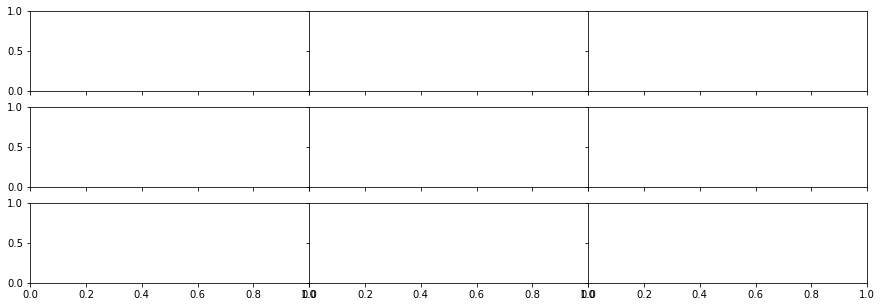

In [49]:
n_likelihood = 3
fig, ax = plt.subplots(n_likelihood, 3, figsize = (15,5), sharex = True, sharey = True)
mean = FM.True_value_0m_s8
plt.subplots_adjust(wspace=0)
for i in range(3):
    cPoiss, cGauss_diag, cGauss, cMVP, cov_SSC_true, cov_Shot_Noise_true = data[i]
    print(cGauss)
    _make_ellipse(mean, cUnbinned, ax[i], color='b', label = r'Poisson Unbinned', ls = '--')
    #_make_ellipse(mean, cPoiss, ax[i], color='b', label = r'Poisson Binned', ls = '-')
    _make_ellipse(mean, cGauss, ax[i], color='r', label = r'Gaussian Binned', ls = '-')
    #_make_ellipse(mean, cGauss_diag, ax[i], color='magenta', label = r'Gaussian Binned (diagonal)', ls = '-')
    #_make_ellipse(mean, cMVP, ax[i], color='g', label = r'MVP Binned', ls = '--')
    std_Om = 0.0028
    std_s8 = 0.0015
    ax[i].set_xlim(mean[0] - std_Om, mean[0] + std_Om)
    ax[i].set_ylim(mean[1] - std_s8, mean[1] + std_s8)
    ax[i].vlines(mean[0], 0, 1, color = 'k', linestyle = '-', linewidth = .5)
    ax[i].hlines(mean[1], 0, 1, color = 'k', linestyle = '-', linewidth = .5)
    ax[i].tick_params(axis='both', which = 'major', labelsize= 15)
    parameters = [r'$\Omega_m$',r'$\sigma_8$']
    ax[i].set_xlabel(parameters[0], fontsize = 30)
    if i==0:
        print(1)
       # ax[i].legend(fontsize = 15, frameon = False)
        ax[i].set_ylabel(parameters[1], fontsize = 30)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/forecast.pdf', bbox_inches='tight', dpi=300)

[[ 9.29562111e-07 -4.75355139e-07]
 [-4.75355139e-07  3.20098734e-07]]
[[ 8.72848631e-07 -4.39890772e-07]
 [-4.39890772e-07  2.97873893e-07]]
[[ 8.54225864e-07 -4.28267090e-07]
 [-4.28267090e-07  2.90609410e-07]]
1


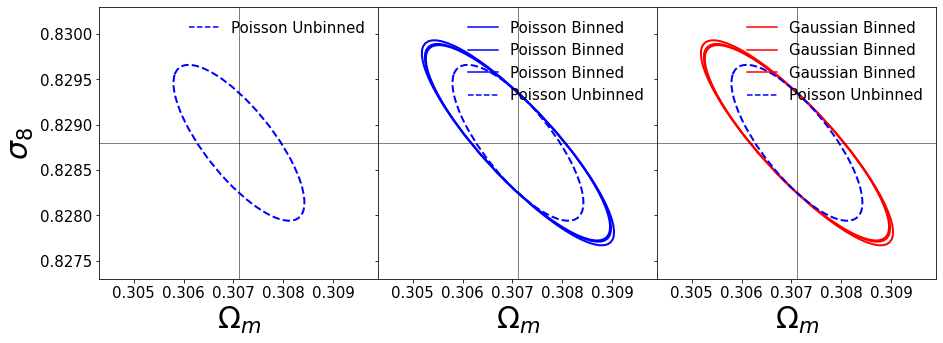

In [50]:
n_likelihood = 3
fig, ax = plt.subplots(1, n_likelihood, figsize = (15,5), sharex = True, sharey = True)
mean = FM.True_value_0m_s8
plt.subplots_adjust(wspace=0)
for i in range(3):
    cPoiss, cGauss_diag, cGauss, cMVP, cov_SSC_true, cov_Shot_Noise_true = data[i]
    print(cGauss)
    _make_ellipse(mean, cPoiss, ax[1], color='b', label = r'Poisson Binned', ls = '-')
    _make_ellipse(mean, cGauss, ax[2], color='r', label = r'Gaussian Binned', ls = '-')
    #_make_ellipse(mean, cGauss_diag, ax[i], color='magenta', label = r'Gaussian Binned (diagonal)', ls = '-')
    #_make_ellipse(mean, cMVP, ax[i], color='g', label = r'MVP Binned', ls = '--')
    
_make_ellipse(mean, cUnbinned, ax[0], color='b', label = r'Poisson Unbinned', ls = '--')  
_make_ellipse(mean, cUnbinned, ax[1], color='b', label = r'Poisson Unbinned', ls = '--')
_make_ellipse(mean, cUnbinned, ax[2], color='b', label = r'Poisson Unbinned', ls = '--')
for i in range(n_likelihood):
    std_Om = 0.0028
    std_s8 = 0.0015
    ax[i].set_xlim(mean[0] - std_Om, mean[0] + std_Om)
    ax[i].set_ylim(mean[1] - std_s8, mean[1] + std_s8)
    ax[i].vlines(mean[0], 0, 1, color = 'k', linestyle = '-', linewidth = .5)
    ax[i].hlines(mean[1], 0, 1, color = 'k', linestyle = '-', linewidth = .5)
    ax[i].tick_params(axis='both', which = 'major', labelsize= 15)
    parameters = [r'$\Omega_m$',r'$\sigma_8$']
    ax[i].set_xlabel(parameters[0], fontsize = 30)
    ax[i].legend(fontsize = 15, frameon = False)
    if i==0:
        print(1)
        ax[i].set_ylabel(parameters[1], fontsize = 30)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/forecast.pdf', bbox_inches='tight', dpi=300)